# 1. 分析数据分布

In [4]:
import json
import numpy as np
import torch
# Load model directly
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

# tokenizer_path = "/home/wangyuxin//.cache/huggingface/hub/models--mistralai--Mixtral-8x7B-Instruct-v0.1/snapshots"
# data_path = '/home/nus-hx/code/Sequence-Scheduling/data/alpaca-train-10k.json'
tokenizer_path = "/home/nus-hx/.cache/huggingface/hub/models--mistralai--Mixtral-8x7B-Instruct-v0.1/snapshots/125c431e2ff41a156b9f9076f744d2f35dd6e67a"
data_path = '/home/nus-hx/code/Sequence-Scheduling/data/alpaca-train-10k.json'
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
print(tokenizer)
def load_json(file):
    with open(file, 'r') as f:
        data = json.load(f)
    return data

alpaca_data = load_json(data_path)

LlamaTokenizerFast(name_or_path='/home/nus-hx/.cache/huggingface/hub/models--mistralai--Mixtral-8x7B-Instruct-v0.1/snapshots/125c431e2ff41a156b9f9076f744d2f35dd6e67a', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}


## 1.1 alpaca数据分析

text length 21 34.1237 287
#tokens 37 58.2928 384


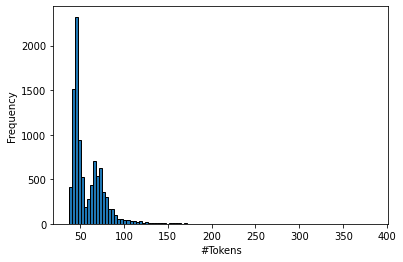

In [10]:
num_samples = len(alpaca_data)
data = {}
lengths = []
tokens = []
for i in range(num_samples):
    prompt = alpaca_data[i]['conversations'][0]['value']
    ids = tokenizer.encode(prompt)
    data[i] = {
        'prompt': prompt,
        'length': len(prompt.split(' ')),    
        'num_tokens': len(ids)    
    }
    lengths.append(len(prompt.split(' ')))
    tokens.append(len(ids))
print('text length', np.min(lengths), np.mean(lengths), np.max(lengths))
print('#tokens', np.min(tokens), np.mean(tokens), np.max(tokens))


# # 示例数据：替换成您的实际数据
# lengths = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60]

# 对长度进行排序
sorted_lengths = sorted(tokens)

# 绘制直方图
plt.hist(sorted_lengths, bins=100, edgecolor='black')

# 添加标题和标签
# plt.title('Token Length Distribution')
plt.xlabel('#Tokens')
plt.ylabel('Frequency')

# 显示图形
plt.show()


## 1.2 Yizhong 数据集


text length 10 127.83606 921
#tokens 25 197.00168 1456


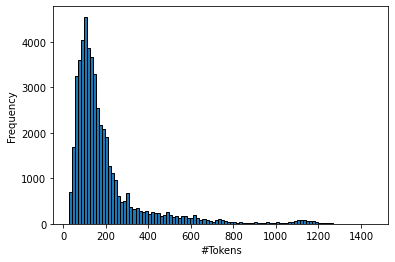

In [9]:
from datasets import load_dataset
dataset = load_dataset("yizhongw/self_instruct", "super_natural_instructions")
data_prompts = dataset['train']['prompt']
num_samples = len(data_prompts)
data = {}
lengths = []
tokens = []
for i in range(num_samples):
    prompt = data_prompts[i]
    ids = tokenizer.encode(prompt)
    data[i] = {
        'prompt': prompt,
        'length': len(prompt.split(' ')),    
        'num_tokens': len(ids)    
    }
    lengths.append(len(prompt.split(' ')))
    tokens.append(len(ids))
print('text length', np.min(lengths), np.mean(lengths), np.max(lengths))
print('#tokens', np.min(tokens), np.mean(tokens), np.max(tokens))

# # 示例数据：替换成您的实际数据
# lengths = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60]

# 对长度进行排序
sorted_lengths = sorted(tokens)

# 绘制直方图
plt.hist(sorted_lengths, bins=100, edgecolor='black')

# 添加标题和标签
# plt.title('Token Length Distribution')
plt.xlabel('#Tokens')
plt.ylabel('Frequency')

# 显示图形
plt.show()


## 1.3 unknown

In [ ]:
import json
import numpy as np
import torch

def load_json(file):
    with open(file, 'r') as f:
        data = json.load(f)
    return data

# data = load_json('/home/nus-hx/code/ColossalAI/examples/language/openmoe/expert_input_statistics_yizhongw.json')
# data = load_json('/home/nus-hx/code/ColossalAI/examples/language/openmoe/expert_input_statistics.json')



In [ ]:
data = load_json("/home/nus-hx/code/Sequence-Scheduling/data/alpaca-train-10k.json")
data[1]['conversations'][0]['value']


'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nExplain why the following fraction is equivalent to 1/4\n\n### Input:\n4/16\n\n### Response:'

In [ ]:
def preprocess(data):
    all_num_tokens_per_expert = []
    # all_id_value_per_expert = []
    for layer_id, layer_expert_info in data.items():
        all_num_tokens_per_expert.append([])
        # all_id_value_per_expert.append([])
        for expert_idx, expert_info in layer_expert_info.items():
            all_num_tokens_per_expert[-1].append(expert_info[1:])
            # all_id_value_per_expert[-1].append(expert_info['id_value_per_expert'])
    return torch.tensor(all_num_tokens_per_expert)
    # return torch.tensor(all_num_tokens_per_expert), torch.tensor(all_id_value_per_expert)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_num_tokens(num_tokens, stpes=5):
    num_layers, num_experts, num_steps = num_tokens.shape
    num_steps = min(stpes, num_steps)
    # 创建一个子图，每个步骤一个子图
    fig, axs = plt.subplots(num_steps, 1, figsize=(num_experts, num_layers * num_steps))

    for step in range(num_steps):
        matrix = num_tokens[:, :, step]

        # 绘制热图
        im = axs[step].imshow(matrix, cmap='viridis')

        # 显示颜色条
        cbar = axs[step].figure.colorbar(im, ax=axs[step])

        # 设置坐标轴标签
        axs[step].set_xticks(np.arange(num_experts))
        axs[step].set_yticks(np.arange(num_layers))
        axs[step].set_xticklabels([f'Expert {i}' for i in range(num_experts)])
        axs[step].set_yticklabels([f'Layer {i}' for i in range(num_layers)])

        # 在矩阵元素上显示数值
        for i in range(num_layers):
            for j in range(num_experts):
                axs[step].text(j, i, f'{matrix[i, j]:.2f}', ha='center', va='center', color='w')

        axs[step].set_title(f'Step {step + 1}')

    # 调整子图布局
    plt.tight_layout()
    plt.show()


In [ ]:
import torch

def kl_divergence(matrix1, matrix2, eps=1e-10):
    """
    计算两个矩阵每一行数据的KL散度（PyTorch版本）
    """
    # 将每一行的数据归一化为概率分布epsilon = 1e-10  # 或者选择适当的小值
    distributions1 = (matrix1 + eps) / torch.sum(matrix1 + eps, dim=1, keepdim=True)
    distributions2 = (matrix2 + eps) / torch.sum(matrix2 + eps, dim=1, keepdim=True)


    # 避免对数计算中出现无穷大值
    distributions1 = torch.where(torch.isnan(distributions1), torch.tensor(0.0), distributions1)
    distributions2 = torch.where(torch.isnan(distributions2), torch.tensor(0.0), distributions2)

    # 计算KL散度
    kl = torch.sum(distributions1 * torch.log(distributions1 / distributions2), dim=1)

    return kl


def jensen_shannon_divergence(matrix1, matrix2, epsilon=1e-10):
    # 将每一行的数据归一化为概率分布
    distributions1 = (matrix1 + epsilon) / (torch.sum(matrix1, dim=1, keepdim=True) + epsilon)
    distributions2 = (matrix2 + epsilon) / (torch.sum(matrix2, dim=1, keepdim=True) + epsilon)

    # 计算平均分布
    average_distribution = 0.5 * (distributions1 + distributions2)

    # 计算KL散度
    kl_divergence1 = torch.sum(distributions1 * torch.log(distributions1 / (average_distribution + epsilon)), dim=1)
    kl_divergence2 = torch.sum(distributions2 * torch.log(distributions2 / (average_distribution + epsilon)), dim=1)

    # 计算Jensen-Shannon散度
    js_divergence = 0.5 * (kl_divergence1 + kl_divergence2)
    similarity = 1 - 2 * js_divergence
    return js_divergence, similarity


In [ ]:
# use cache
data = load_json('/home/nus-hx/code/vllm/examples/4_expert_input_statistics.json')
num_tokens = preprocess(data) # (num_layers, num_experts, num_steps)
prefilling = num_tokens[..., 0]
decoding = num_tokens[..., 1:].sum(-1)
js, sim = jensen_shannon_divergence(prefilling, decoding)
# print(f"prefilling #tokens: {prefilling}")
# print(f"decoding #tokens: {decoding}")
print(f"js: {js.numpy()} 相似度: {sim}\n")

import numpy as np
from scipy.stats import spearmanr, pearsonr

# 创建两个示例矩阵
matrix1 = prefilling
matrix2 = decoding

# 计算Pearson相关系数
pearson_corr, _ = pearsonr(matrix1.flatten(), matrix2.flatten())
print(f"Pearson Correlation: {pearson_corr}")

# 计算Spearman等级相关系数
spearman_corr, _ = spearmanr(matrix1.flatten(), matrix2.flatten())
print(f"Spearman Rank Correlation: {spearman_corr}")

print(sim.mean())

js: [0.0535679  0.01546035 0.02906168 0.0134853  0.01635661 0.02407915
 0.06574866 0.1114352  0.08775527 0.08032545 0.02912238 0.02791613
 0.0416973  0.01863671 0.03236634 0.01655562 0.05890179 0.01565264
 0.02222927 0.01864578 0.077422   0.00626483 0.09608104 0.04317078
 0.04236926 0.03480298 0.03899682 0.02798922 0.03043891 0.01676919
 0.01555431 0.1200597 ] 相似度: tensor([0.8929, 0.9691, 0.9419, 0.9730, 0.9673, 0.9518, 0.8685, 0.7771, 0.8245,
        0.8393, 0.9418, 0.9442, 0.9166, 0.9627, 0.9353, 0.9669, 0.8822, 0.9687,
        0.9555, 0.9627, 0.8452, 0.9875, 0.8078, 0.9137, 0.9153, 0.9304, 0.9220,
        0.9440, 0.9391, 0.9665, 0.9689, 0.7599])

Pearson Correlation: 0.2905695381201951
Spearman Rank Correlation: 0.20819448895491566
tensor(0.9169)


In [ ]:
plot_num_tokens(num_tokens, 10)


In [ ]:
for i in range(1, 10):
    data = load_json(f'/home/nus-hx/code/ColossalAI/examples/language/openmoe/{i}_expert_input_statistics.json')
    num_tokens, id_values = preprocess(data) # (num_layers, num_experts, num_steps)
    prefilling = num_tokens[..., 0]
    decoding = num_tokens[..., 1:].sum(-1)
    js, sim = jensen_shannon_divergence(prefilling, decoding)
    print(f"{i}-th sample:")
    print(f"prefilling #tokens: {prefilling}")
    print(f"decoding #tokens: {decoding}")
    print(f"js: {js.numpy()} 相似度: {sim}\n")

1-th sample:
prefilling #tokens: tensor([[ 0.,  0., 36., 24., 12., 32., 26., 28., 39., 19., 29., 25., 24., 16.,
         33., 29.],
        [ 0.,  0., 13., 26., 28., 25., 37., 17., 30., 16., 25., 45., 18., 24.,
         30., 38.],
        [ 0.,  0.,  5., 26.,  6., 58., 34., 37., 34.,  8., 28., 27., 38., 38.,
         16., 17.]])
decoding #tokens: tensor([[ 0.,  0.,  0.,  0.,  0., 62.,  0.,  0., 62.,  0.,  1.,  0.,  0.,  0.,
          0.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0., 62.,  0.,  1.,  0.,  0.,
         62.,  0.],
        [ 0.,  0., 62.,  0.,  1.,  0.,  5., 57.,  1.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.]])
js: [0.40641308 0.4757843  0.47032437] 相似度: tensor([0.1872, 0.0484, 0.0594])

2-th sample:
prefilling #tokens: tensor([[ 0.,  0.,  3.,  4.,  3.,  4.,  6.,  3., 14.,  4.,  8.,  3.,  5.,  6.,
          4.,  9.],
        [ 0.,  0.,  3.,  6., 10.,  9.,  5.,  4.,  1.,  3., 11.,  8.,  6.,  7.,
          3.,  0.],
        [ 0.,  0.,  1.,  0.,  0., 12.,  6., 

In [ ]:
plot_num_tokens(num_tokens, 10)

[[ 0.  0. 11.  7.  9. 31.  0.  6. 33.  3.  2.  5.  6.  6.  2.  5.]
 [ 0.  0.  6.  6.  2.  6.  8.  3.  6. 31.  8.  4.  2.  3. 37.  4.]
 [ 0.  0. 35.  0.  2.  9. 13. 10. 28.  3.  0.  5.  3.  8.  3.  7.]]


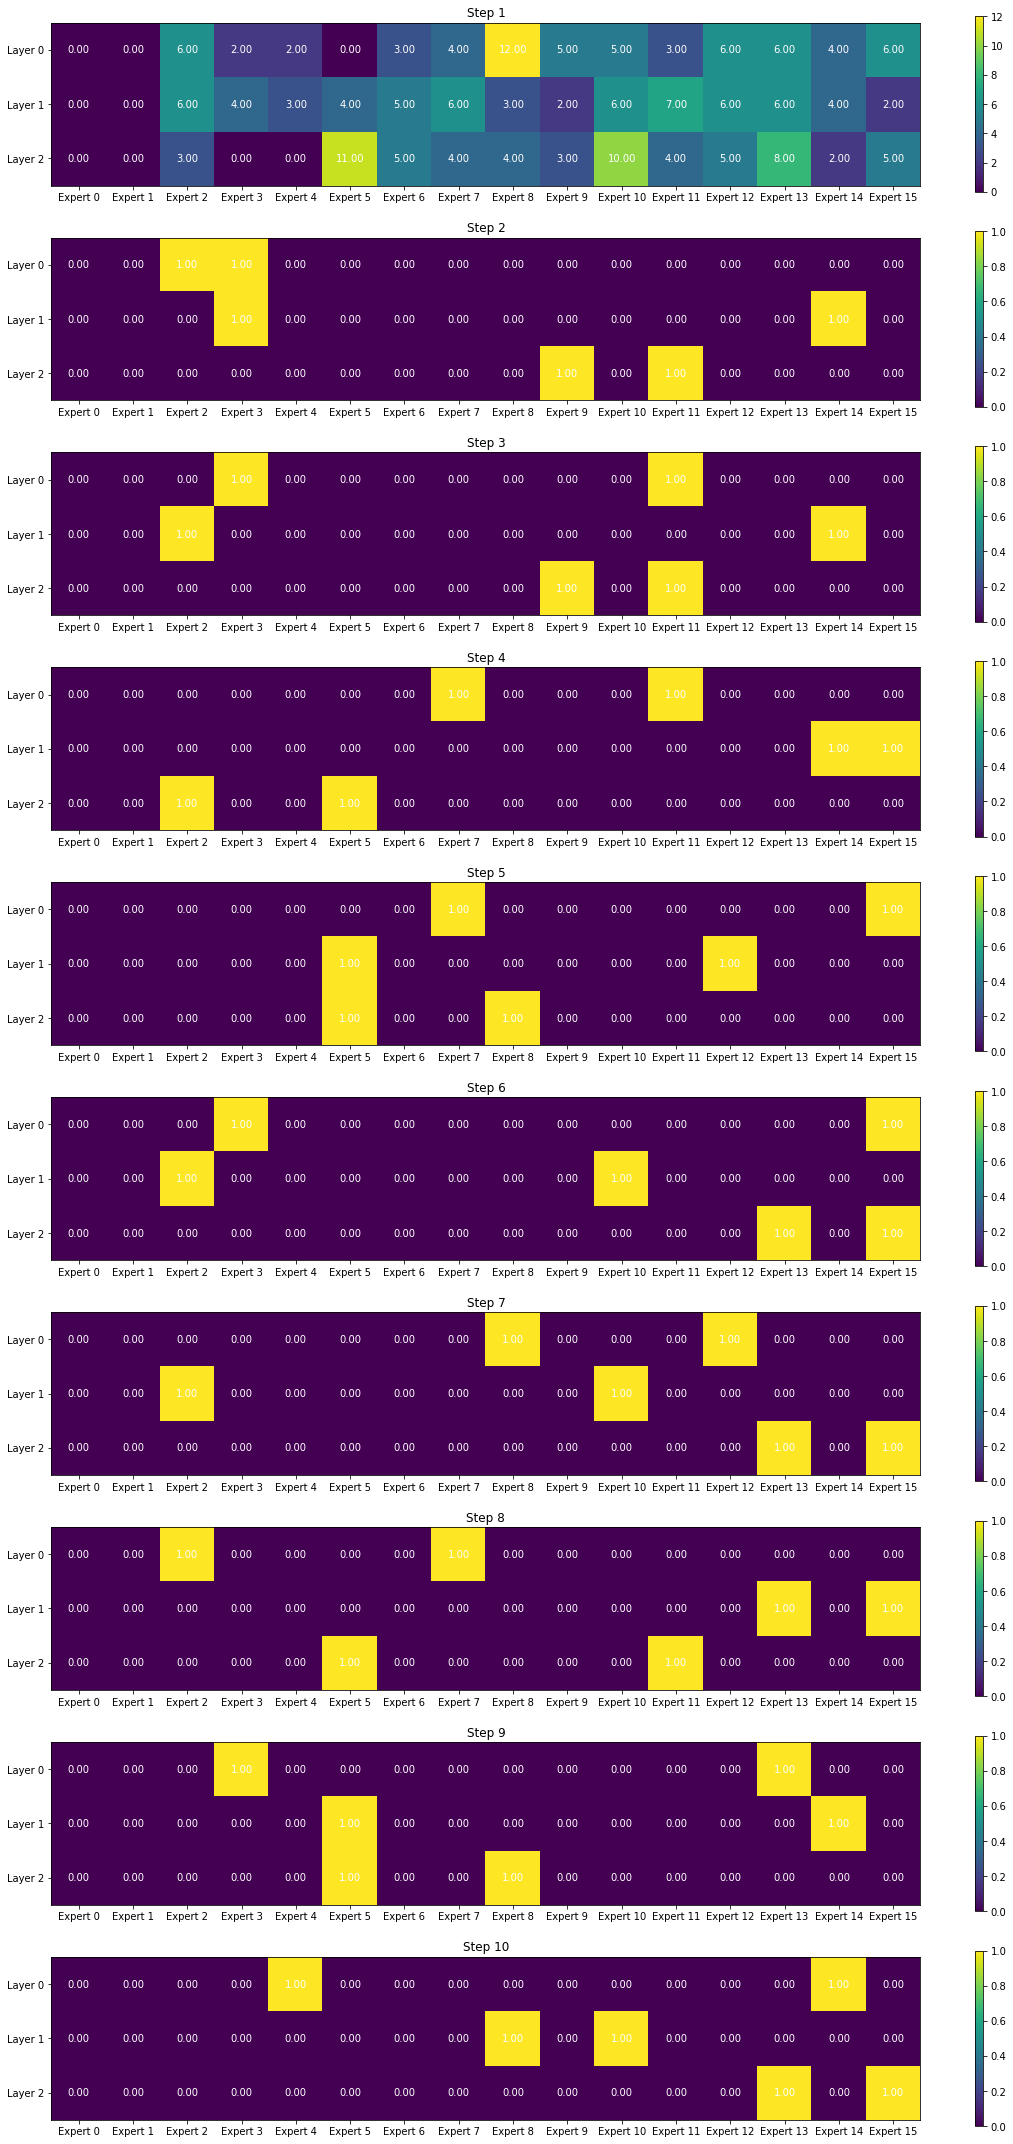

## use cache
data = load_json('/home/nus-hx/code/ColossalAI/examples/language/openmoe/expert_input_statistics_no_cache.json')
num_tokens, id_values = preprocess(data)
for step in range(10):
    print(num_tokens[0,:,step].numpy(), num_tokens[0,:,step].numpy().sum())

In [ ]:
def preprocess(data):
    id_means = []
    id_stds = []
    for layer_id, layer_expert_info in data.items():
        id_means.append([])
        id_stds.append([])
        for expert_idx, expert_info in layer_expert_info.items():
            id_means[-1].append(np.mean(expert_info))
            id_stds[-1].append(np.std(expert_info))
    id_means, id_stds = np.array(id_means), np.array(id_stds)
#     print('means:\n', id_means)
#     print('stds:\n', id_stds)
    return id_means, id_stds

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mean_variance(matrix_mean, matrix_var, is_sort=True):
    if is_sort:
        # 对均值矩阵按行排序
        sorted_indices = np.argsort(matrix_mean, axis=1)
        sorted_matrix_mean = np.take_along_axis(matrix_mean, sorted_indices, axis=1)
        sorted_matrix_var = np.take_along_axis(matrix_var, sorted_indices, axis=1)
    else:
        sorted_matrix_mean = matrix_mean
        sorted_matrix_var = matrix_var

    num_layers, num_experts = sorted_matrix_mean.shape

    plt.figure(figsize=(10, 6 * num_layers))  # 设置图表尺寸，每一层一个子图

    for layer in range(num_layers):
        plt.subplot(num_layers, 1, layer + 1)  # 创建子图
        mean_values = sorted_matrix_mean[layer]  # 获取当前层的均值
        var_values = sorted_matrix_var[layer]  # 获取当前层的方差

        # 绘制图表，均值用条形图表示，方差用error bar表示
        plt.bar(np.arange(num_experts), mean_values, yerr=var_values, capsize=5)
        plt.xlabel('Expert Index')
        plt.ylabel('Mean Value')
        plt.title(f'Layer {layer + 1}')

    plt.tight_layout()  # 调整布局
    plt.show()

# # 测试示例
# num_layer = 4
# num_expert = 6
# matrix_mean = np.random.randint(1, 50, size=(num_layer, num_expert))  # 生成随机均值矩阵
# matrix_var = np.random.randint(1, 20, size=(num_layer, num_expert))  # 生成随机方差矩阵
# print("原始均值矩阵：")
# print(matrix_mean)
# print("原始方差矩阵：")
# print(matrix_var)
# plot_mean_variance(matrix_mean, matrix_var, is_sort=False)


In [ ]:
data_yizhongw = preprocess(load_json('/home/nus-hx/code/ColossalAI/examples/language/openmoe/expert_input_statistics_yizhongw.json'))
# data_wikitext = preprocess(load_json('/home/nus-hx/code/ColossalAI/examples/language/openmoe/expert_input_statistics_wikitext.json'))
data_wikitext = preprocess(load_json('/home/nus-hx/code/ColossalAI/examples/language/openmoe/expert_input_statistics.json'))

/home/nus-hx/.conda/envs/moe/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nus-hx/.conda/envs/moe/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/nus-hx/.conda/envs/moe/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/nus-hx/.conda/envs/moe/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/nus-hx/.conda/envs/moe/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/home/nus-hx/.conda/envs/moe/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/nus-hx/.conda/envs/moe/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/nus-hx/.conda/envs/moe/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/nus-hx/.conda/envs/moe/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/nus-hx/.conda/envs/moe/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, i

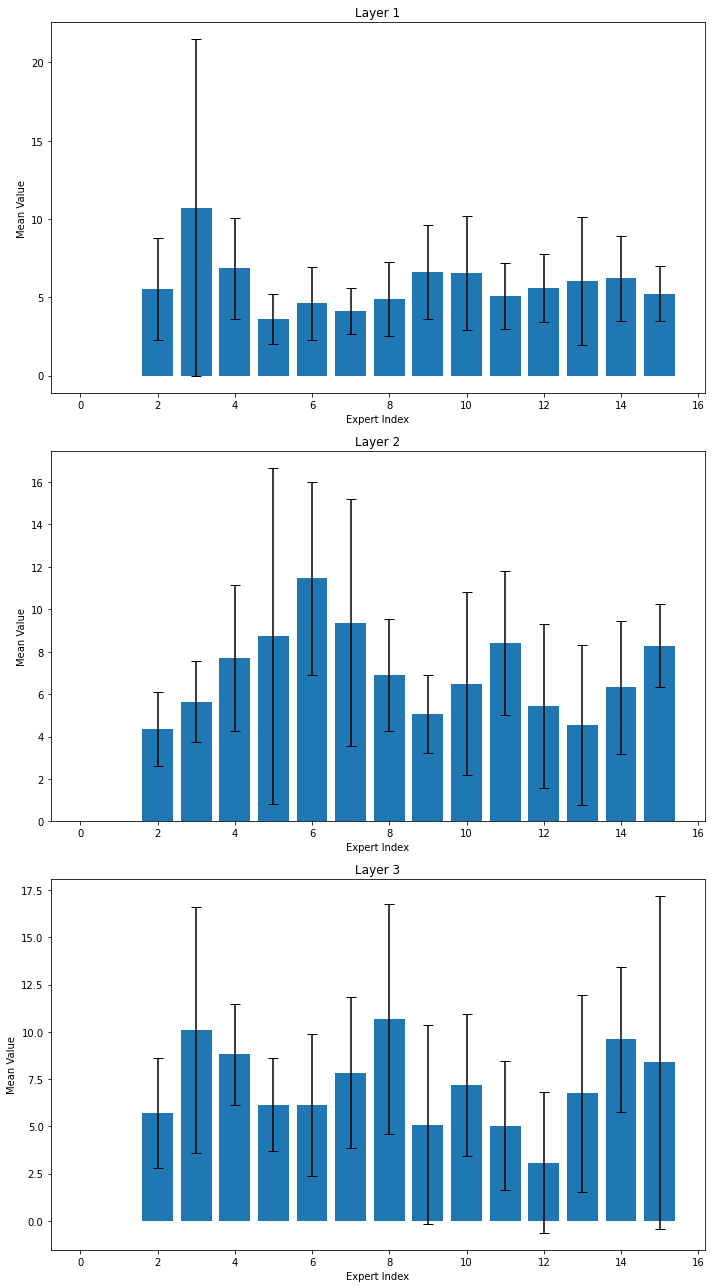

In [ ]:
plot_mean_variance(*data_yizhongw, False)

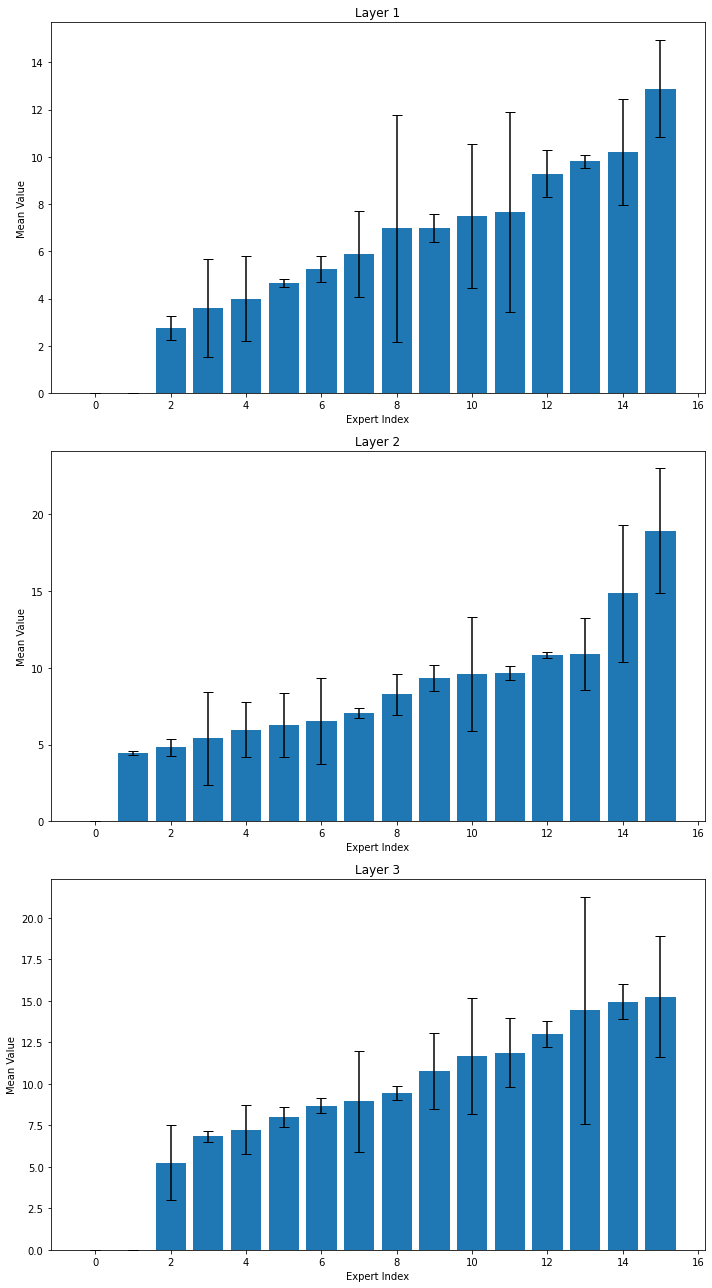

In [ ]:
plot_mean_variance(*data_wikitext, True)

原始矩阵：
[[ 0.        0.        5.544073 10.722609  6.840683  3.627592  4.612808
   4.135404  4.916871  6.61953   6.562585  5.101259  5.618176  6.03778
   6.207156  5.236032]
 [ 0.        0.        4.355231  5.640529  7.701429  8.725691 11.453165
   9.376528  6.904047  5.065467  6.500171  8.404157  5.460723  4.534373
   6.314137  8.272322]
 [ 0.        0.        5.698514 10.105216  8.807961  6.142078  6.140738
   7.836411 10.673695  5.086765  7.178852  5.035629  3.078635  6.750798
   9.594976  8.384435]]
排序后矩阵：
 [[ 0.        0.        3.627592  4.135404  4.612808  4.916871  5.101259
   5.236032  5.544073  5.618176  6.03778   6.207156  6.562585  6.61953
   6.840683 10.722609]
 [ 0.        0.        4.355231  4.534373  5.065467  5.460723  5.640529
   6.314137  6.500171  6.904047  7.701429  8.272322  8.404157  8.725691
   9.376528 11.453165]
 [ 0.        0.        3.078635  5.035629  5.086765  5.698514  6.140738
   6.142078  6.750798  7.178852  7.836411  8.384435  8.807961  9.594976
  10.105

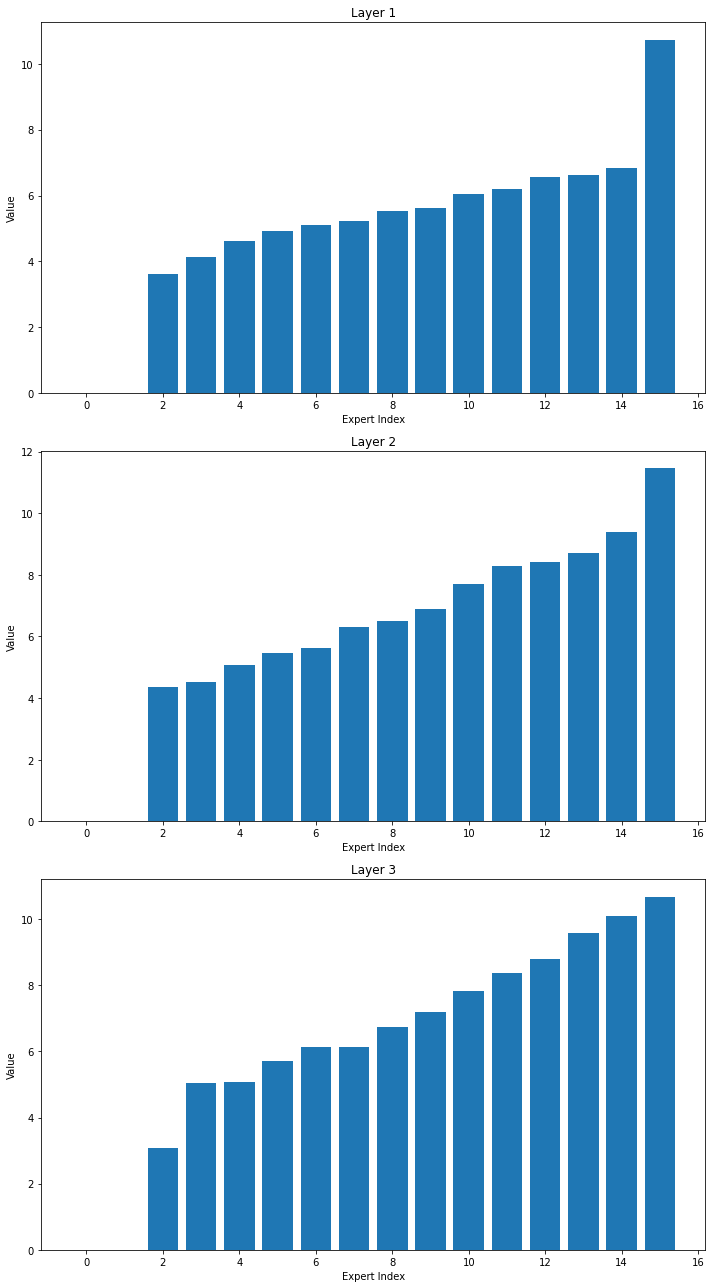

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_expert_values(matrix, to_sort=False):
    sorted_matrix = matrix
    if to_sort:
        sorted_matrix = np.sort(matrix, axis=1)  # 对矩阵按行排序
        print(f"排序后矩阵：\n", sorted_matrix)

    num_layers, num_experts = sorted_matrix.shape

    plt.figure(figsize=(10, 6 * num_layers))  # 设置图表尺寸，每一层一个子图

    for layer in range(num_layers):
        plt.subplot(num_layers, 1, layer + 1)  # 创建子图
        values = sorted_matrix[layer]  # 获取当前层的数值

        # 绘制图表
        plt.bar(np.arange(num_experts), values)
        plt.xlabel('Expert Index')
        plt.ylabel('Value')
        plt.title(f'Layer {layer + 1}')

    plt.tight_layout()  # 调整布局
    plt.show()

# 测试示例
num_layer = 4
num_expert = 6
matrix = np.random.randint(1, 50, size=(num_layer, num_expert))  # 生成随机矩阵


# results on yizhongw
matrix = [   
    [0,0,5.544073,10.722609,6.840683,3.627592,4.612808,4.135404,4.916871,6.619530,6.562585,5.101259,5.618176,6.037780,6.207156,5.236032],
    [0,0,4.355231,5.640529,7.701429,8.725691,11.453165,9.376528,6.904047,5.065467,6.500171,8.404157,5.460723,4.534373,6.314137,8.272322],
    [0,0,5.698514,10.105216,8.807961,6.142078,6.140738,7.836411,10.673695,5.086765,7.178852,5.035629,3.078635,6.750798,9.594976,8.384435]
]
matrix = np.array(matrix)
matrix = np.nan_to_num(matrix)
print("原始矩阵：")
print(matrix)
plot_expert_values(matrix, True)


原始矩阵：
[[ 0.        0.        5.544073 10.722609  6.840683  3.627592  4.612808
   4.135404  4.916871  6.61953   6.562585  5.101259  5.618176  6.03778
   6.207156  5.236032]
 [ 0.        0.        4.355231  5.640529  7.701429  8.725691 11.453165
   9.376528  6.904047  5.065467  6.500171  8.404157  5.460723  4.534373
   6.314137  8.272322]
 [ 0.        0.        5.698514 10.105216  8.807961  6.142078  6.140738
   7.836411 10.673695  5.086765  7.178852  5.035629  3.078635  6.750798
   9.594976  8.384435]]
排序后矩阵：
 [[ 0.        0.        3.627592  4.135404  4.612808  4.916871  5.101259
   5.236032  5.544073  5.618176  6.03778   6.207156  6.562585  6.61953
   6.840683 10.722609]
 [ 0.        0.        4.355231  4.534373  5.065467  5.460723  5.640529
   6.314137  6.500171  6.904047  7.701429  8.272322  8.404157  8.725691
   9.376528 11.453165]
 [ 0.        0.        3.078635  5.035629  5.086765  5.698514  6.140738
   6.142078  6.750798  7.178852  7.836411  8.384435  8.807961  9.594976
  10.105

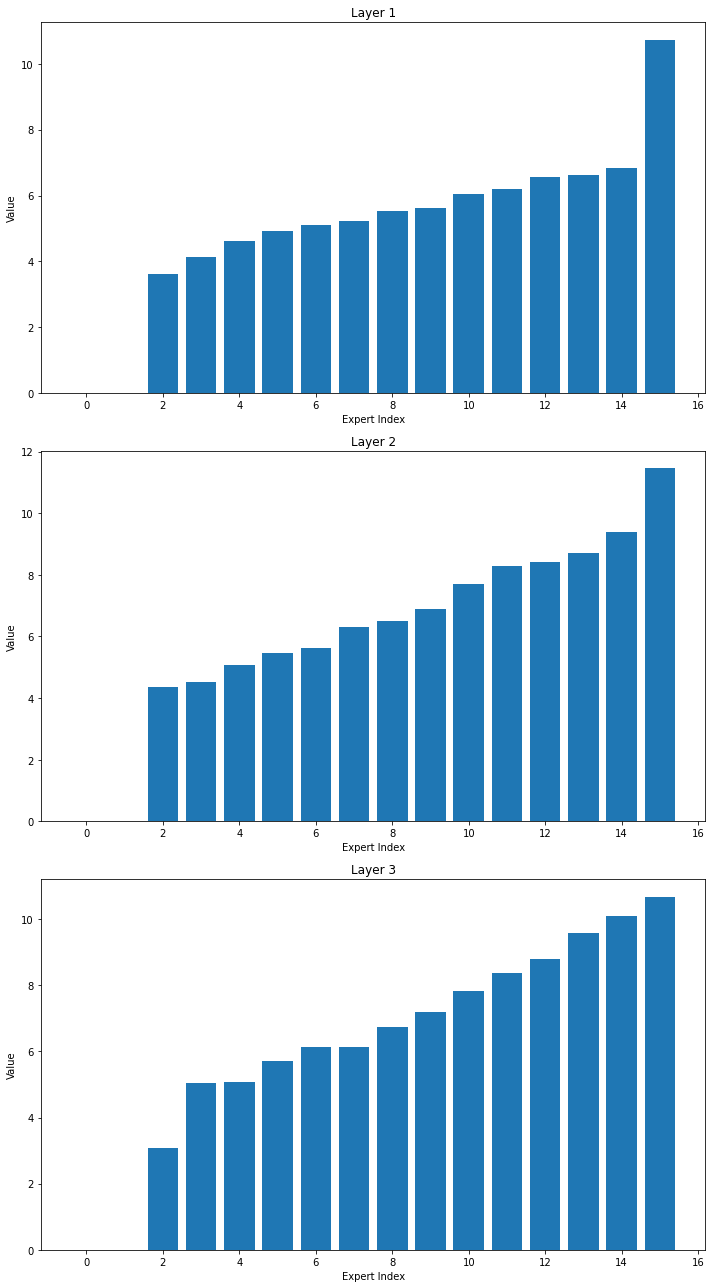

In [ ]:
matrix = [
    [0,0,5.544073,10.722609,6.840683,3.627592,4.612808,4.135404,4.916871,6.619530,6.562585,5.101259,5.618176,6.037780,6.207156,5.236032],
    [0,0,4.355231,5.640529,7.701429,8.725691,11.453165,9.376528,6.904047,5.065467,6.500171,8.404157,5.460723,4.534373,6.314137,8.272322],
    [0,0,5.698514,10.105216,8.807961,6.142078,6.140738,7.836411,10.673695,5.086765,7.178852,5.035629,3.078635,6.750798,9.594976,8.384435],
]

matrix = np.array(matrix)
matrix = np.nan_to_num(matrix)
print("原始矩阵：")
print(matrix)
plot_expert_values(matrix, True)

原始矩阵：
[[ 0.        0.        7.963334  7.24861   5.389153  5.79661   4.887456
   5.961907  5.427928  5.641143  3.553481  4.450169  6.972357  4.594432
   8.926065  7.169308]
 [ 0.       10.37379   6.114333 11.607411 11.788904 12.56812   9.828843
   9.701502  9.9606    5.349957  8.947469 11.169651  6.741775  8.415722
   8.856209  8.982792]
 [ 0.        0.        5.87593   7.778467  9.251879 11.587394 13.382789
  10.92747  10.783409  9.167251 11.630848  9.831821 13.27439   6.963855
  12.515475  8.359204]]


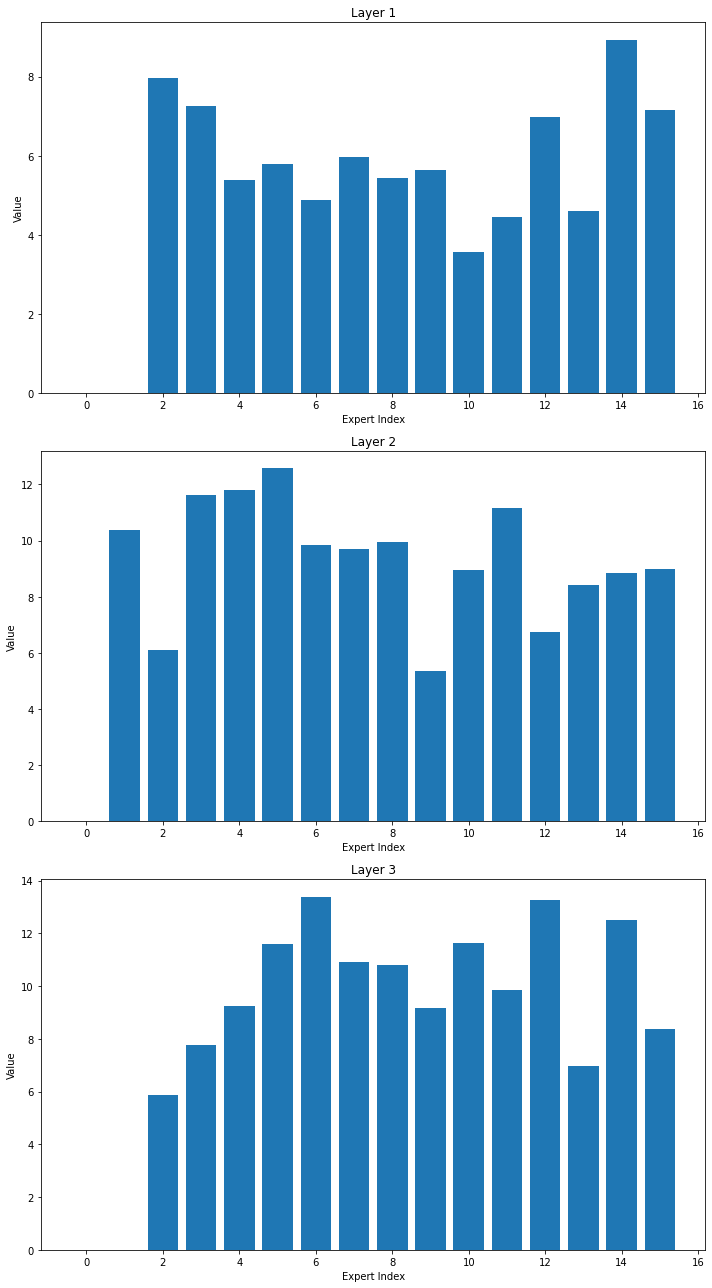

In [ ]:
# results on Wikitext-2-v1

matrix = [
    [0.000000,0.000000,7.963334,7.248610,5.389153,5.796610,4.887456,5.961907,5.427928,5.641143,3.553481,4.450169,6.972357,4.594432,8.926065,7.169308],
[0.000000,10.373790,6.114333,11.607411,11.788904,12.568120,9.828843,9.701502,9.960600,5.349957,8.947469,11.169651,6.741775,8.415722,8.856209,8.982792],
[0.000000,0.000000,5.875930,7.778467,9.251879,11.587394,13.382789,10.927470,10.783409,9.167251,11.630848,9.831821,13.274390,6.963855,12.515475,8.359204]
]

matrix = np.array(matrix)
matrix = np.nan_to_num(matrix)
print("原始矩阵：")
print(matrix)
plot_expert_values(matrix)

排序后矩阵：
 [[ 0.        0.        3.553481  4.450169  4.594432  4.887456  5.389153
   5.427928  5.641143  5.79661   5.961907  6.972357  7.169308  7.24861
   7.963334  8.926065]
 [ 0.        5.349957  6.114333  6.741775  8.415722  8.856209  8.947469
   8.982792  9.701502  9.828843  9.9606   10.37379  11.169651 11.607411
  11.788904 12.56812 ]
 [ 0.        0.        5.87593   6.963855  7.778467  8.359204  9.167251
   9.251879  9.831821 10.783409 10.92747  11.587394 11.630848 12.515475
  13.27439  13.382789]]


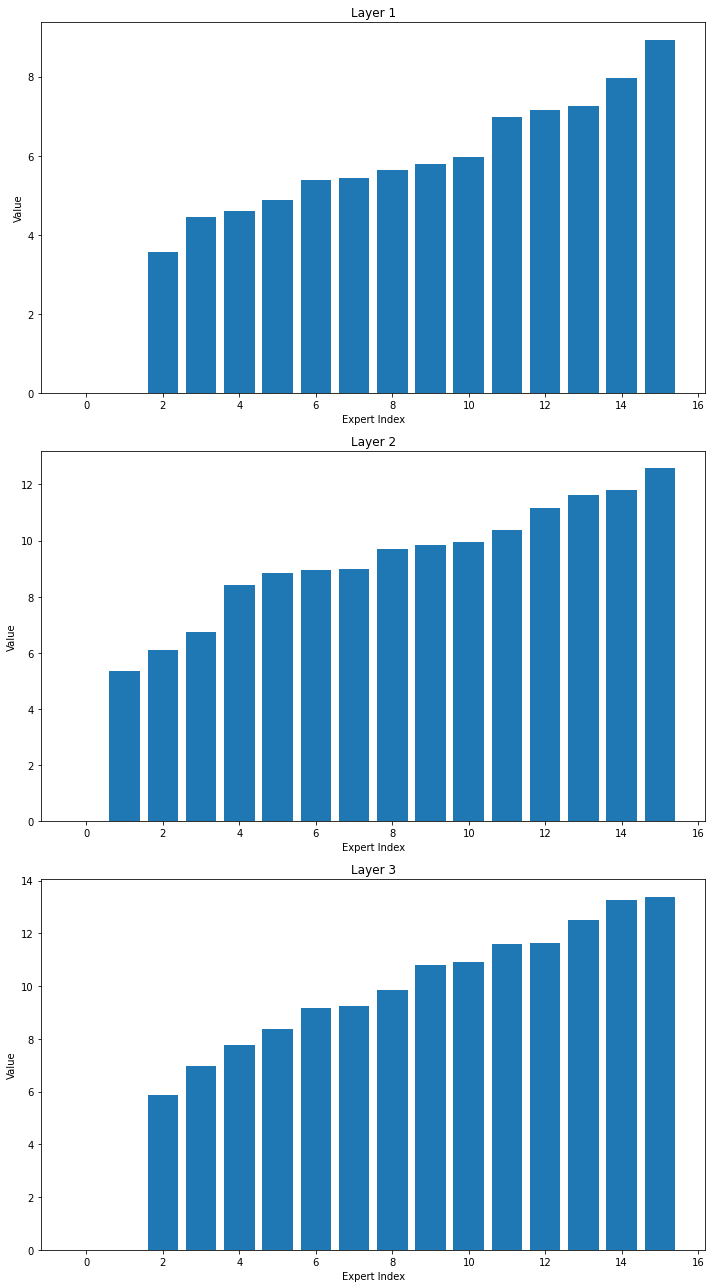

In [ ]:

plot_expert_values(matrix, True)

# 1. 导入依赖库和数据

In [21]:
import torch
import numpy as np
num_samples = 10000
# pt = torch.load(f'../alpaca_{num_samples}_samples.pt')
pt = torch.load(f'../yizhong_{num_samples}_samples.pt')
type(pt), len(pt)

(list, 10000)

# 2. 定义数据解析函数

In [4]:

def get_prompt_expert_trace(seq_group):
    t2e = seq_group.token2experts
    seq = seq_group.get_seqs()[0]
    num_layers = len(t2e[0]) - 1
    num_experts = 8
    expert_trace = torch.zeros((num_layers, num_experts)).to(torch.cuda.current_device())
    prompt_len = seq.get_prompt_len()
    for i_token in range(prompt_len):
        for layer_id in t2e[i_token]:
            if isinstance(layer_id, int):
                experts = t2e[i_token][layer_id][0]
                for expert_id in experts:
                    expert_trace[layer_id][expert_id] += 1
    return expert_trace

def get_output_expert_trace(seq_group):
    t2e = seq_group.token2experts
    seq = seq_group.get_seqs()[0]
    num_layers = len(t2e[0]) - 1
    num_experts = 8
    expert_trace = torch.zeros((num_layers, num_experts)).to(torch.cuda.current_device())
    prompt_len = seq.get_prompt_len()
    output_len = len(seq.get_output_token_ids())
    all_length = len(seq.get_token_ids())
    # print(f"all:{all_length}=prompt({prompt_len}) + output({output_len})")
    assert prompt_len+output_len == all_length
    for i_token in range(prompt_len, all_length-1):
        for layer_id in t2e[i_token]:
            if isinstance(layer_id, int):
                experts = t2e[i_token][layer_id][0]
                for expert_id in experts:
                    expert_trace[layer_id][expert_id] += 1
    return expert_trace

def parse_seq_group(seq_group):
    prompt_expert_trace = get_prompt_expert_trace(seq_group)
    output_expert_trace = get_output_expert_trace(seq_group)
    seq = seq_group.get_seqs()[0]
    token_ids = seq.get_token_ids()
    prompt_len = seq.get_prompt_len()
    prompt_ids = token_ids[:prompt_len]
    output_ids = seq.get_output_token_ids()
    output_len = len(output_ids)
    return {
        'prompt_ids': prompt_ids,
        'output_ids': output_ids,
        'token_ids': token_ids,
        'prompt_len': prompt_len,
        'output_len': output_len,
        'prompt_expert_trace': prompt_expert_trace,
        'output_expert_trace': output_expert_trace
    }

def get_token_expert_trace(per_token2experts):
    trace = []
    for i in range(len(per_token2experts)-1):
        trace.append(per_token2experts[i][0])
    return torch.from_numpy(np.array(trace))


In [14]:

seq_group = pt[0].outputs[0].seq_group
token2experts = seq_group.token2experts
seq = seq_group.get_seqs()[0]

data = parse_seq_group(seq_group)
data.keys(), data['prompt_expert_trace'][:5], get_token_expert_trace(seq_group.token2experts[0])[:5]

token_ids = seq.get_token_ids()
output_ids = seq.get_output_token_ids()
prompt_len = seq.get_prompt_len()
print(f'length: {len(token_ids)}={prompt_len}+{len(output_ids)}')
print('All:', token_ids)
print('prompt:', token_ids[:prompt_len])
print('output:', output_ids)
unique_ids = []
repeat_ids = {}
for i, idx in enumerate(token_ids):
    if idx not in unique_ids:
        unique_ids.append(idx)
    else:
        if idx not in repeat_ids:
            repeat_ids[idx] = [i]
        else:
            repeat_ids[idx].append(i)
print('unique:', f"{len(unique_ids)}/{seq.get_len()}")
print('repeat:', repeat_ids)

length: 183=180+3
All: [1, 995, 622, 347, 2078, 989, 7769, 302, 2245, 395, 272, 1348, 5746, 28723, 2387, 302, 706, 349, 27013, 304, 7089, 298, 2380, 354, 1843, 28733, 14305, 4300, 20872, 28723, 26967, 19337, 993, 7001, 680, 3796, 3085, 28725, 506, 22376, 27512, 442, 7001, 1043, 23748, 28723, 3604, 3638, 349, 298, 4987, 272, 27013, 5511, 302, 2245, 28723, 995, 460, 3349, 298, 3825, 464, 1874, 624, 28742, 513, 272, 907, 12271, 349, 27013, 28723, 15510, 3825, 464, 1874, 989, 4135, 13, 13, 3104, 28747, 7379, 624, 28747, 415, 1850, 18723, 298, 4337, 9923, 28725, 562, 3769, 16030, 4475, 294, 24038, 28725, 746, 5330, 325, 615, 16030, 4475, 294, 746, 5330, 557, 389, 2504, 28706, 28725, 6588, 7533, 28725, 290, 2158, 274, 28725, 304, 285, 1173, 28713, 2588, 390, 1162, 28723, 13, 7379, 989, 28747, 415, 1850, 18723, 298, 4337, 9923, 28725, 562, 3769, 16030, 4475, 294, 24038, 28725, 746, 5330, 325, 615, 16030, 4475, 294, 746, 5330, 557, 389, 2504, 28706, 28725, 6588, 7533, 28725, 290, 2158, 274, 28

# 3. 解析数据

## 3.1 分析单个 token 的 expert_trace

查看分析单个 token 的 expert_trace是否与上下文无关

In [23]:
# 计算指定 token 的 expert_trace (L,2)在不同上下文的相似性
def get_consistency_score_token_expert_trace(t2e_pool, token_idx: int):
    data = torch.stack( t2e_pool[token_idx]['trace'] ).sort(-1)
    scores = torch.zeros(len(data), len(data))
    for i in range(len(data)):
        scores[i,i] = 1.
        for j in range(i+1, len(data)):
            tet1 = data[i].sort()[0]
            tet2 = data[j].sort()[0]
            score = (tet1==tet2).sum() / tet1.numel()
            scores[i,j] = score
            scores[j,i] = score
    return scores

### Prefilling和Decoding整体上下文情况下token 的 expert_trace (L,2)在不同上下文的相似性

In [16]:
t2e_pool = {
    # 'token_id': {
    #     'trace': [
    #         [token_expert_trace], [token_expert_trace]
    #         ],
    #         'position': [18, 19]
    #     }
    # },
}
seq_group_list = [pt[i].outputs[0].seq_group for i in range(len(pt))]
for seq_group in seq_group_list:
    crt_t2e = seq_group.token2experts
    for i in range(len(crt_t2e)):
        crt_token_t2e = crt_t2e[i]
        token_idx = crt_token_t2e['token_idx']
        token_expert_trace = get_token_expert_trace(crt_token_t2e)
        if token_idx not in t2e_pool:
            t2e_pool[token_idx] = {'position': [], 'trace': []}
        t2e_pool[token_idx]['position'].append(i)
        t2e_pool[token_idx]['trace'].append(token_expert_trace)
print(len(t2e_pool), t2e_pool.keys())
token_expert_trace_consistence = [
    # token_idx, score
]
for i, token_idx in enumerate(t2e_pool):
    if len(t2e_pool[token_idx]) > 1:
        score = get_consistency_score_token_expert_trace(t2e_pool, token_idx).mean()
        token_expert_trace_consistence.append([token_idx, score])
np.array(token_expert_trace_consistence)[:10:20].tolist()


10842 dict_keys([1, 995, 622, 347, 2078, 989, 7769, 302, 2245, 395, 272, 1348, 5746, 28723, 2387, 706, 349, 27013, 304, 7089, 298, 2380, 354, 1843, 28733, 14305, 4300, 20872, 26967, 19337, 993, 7001, 680, 3796, 3085, 28725, 506, 22376, 27512, 442, 1043, 23748, 3604, 3638, 4987, 5511, 460, 3349, 3825, 464, 1874, 624, 28742, 513, 907, 12271, 15510, 4135, 13, 3104, 28747, 7379, 415, 1850, 18723, 4337, 9923, 562, 3769, 16030, 4475, 294, 24038, 746, 5330, 325, 615, 557, 389, 2504, 28706, 6588, 7533, 290, 2158, 274, 285, 1173, 28713, 2588, 390, 1162, 4792, 560, 456, 368, 927, 4372, 5166, 23817, 2996, 356, 16173, 4950, 1575, 574, 11194, 778, 28708, 647, 28726, 28717, 28715, 24857, 264, 12048, 5211, 11459, 297, 28705, 28770, 3316, 842, 1096, 24798, 1200, 378, 2056, 28734, 1187, 767, 727, 541, 18946, 575, 544, 2130, 1038, 4606, 1550, 4018, 1143, 28750, 295, 4586, 287, 28740, 277, 281, 317, 28781, 4714, 3236, 1274, 3113, 7850, 1023, 3713, 1430, 11584, 17403, 19391, 1633, 1725, 2825, 1474, 733, 2

[[1.0, 0.5234375]]

In [17]:
min_mean_max_std = lambda x: (x.min(), x.mean(), x.max(), x.std())
min_mean_max_std(np.array(token_expert_trace_consistence)[:,1])

(0.5078125, 0.5696445837427254, 0.6640625, 0.019892463911457138)

### Prefilling上下文情况下token 的 expert_trace (L,2)在不同上下文的相似性

In [24]:
t2e_pool = {
    # 'token_id': {
    #     'trace': [
    #         [token_expert_trace], [token_expert_trace]
    #         ],
    #         'position': [18, 19]
    #     }
    # },
}
seq_group_list = [pt[i].outputs[0].seq_group for i in range(len(pt))]
for seq_group in seq_group_list:
    crt_t2e = seq_group.token2experts
    seq = seq_group.get_seqs()[0]
    prompt_len = seq.get_prompt_len()
    for i in range(prompt_len):
        crt_token_t2e = crt_t2e[i]
        token_idx = crt_token_t2e['token_idx']
        token_expert_trace = get_token_expert_trace(crt_token_t2e)
        if token_idx not in t2e_pool:
            t2e_pool[token_idx] = {'position': [], 'trace': []}
        t2e_pool[token_idx]['position'].append(i)
        t2e_pool[token_idx]['trace'].append(token_expert_trace)
print(len(t2e_pool), t2e_pool.keys())
token_expert_trace_consistence = [
    # token_idx, min_score, mean_score
]
for token_idx in t2e_pool:
    if len(t2e_pool[token_idx]) > 1:
        scores = get_consistency_score_token_expert_trace(t2e_pool, token_idx)
        token_expert_trace_consistence.append([token_idx, scores.min().item(), scores.mean().item()])
token_expert_trace_consistence = np.array(token_expert_trace_consistence)
min_mean_max_std = lambda x: (x.min(), x.mean(), x.max(), x.std())
min_mean_max_std(np.array(token_expert_trace_consistence)[:,2])


20288 dict_keys([1, 995, 460, 2078, 264, 2939, 1141, 304, 368, 927, 298, 604, 272, 15547, 302, 28723, 13, 3104, 28747, 19652, 4792, 21935, 18001, 441, 22549, 26791, 18049, 18418, 396, 521, 6159, 4300, 12271, 28725, 6782, 1846, 378, 354, 3964, 13544, 6248, 1207, 19122, 848, 1679, 1707, 297, 11192, 318, 308, 636, 6190, 1259, 390, 7402, 15828, 1700, 385, 6201, 28709, 3945, 4877, 365, 8775, 426, 12628, 10469, 2996, 8270, 4714, 4372, 1824, 1235, 1012, 4580, 16670, 369, 10589, 3573, 1032, 28804, 23821, 1274, 349, 11301, 6100, 8155, 408, 1593, 2556, 4157, 17542, 8806, 593, 3986, 5670, 1778, 1606, 6274, 326, 3212, 28713, 2401, 1987, 739, 3206, 13455, 6431, 13387, 6251, 10932, 3539, 476, 25111, 9259, 2787, 2111, 871, 2485, 28730, 24115, 3825, 28705, 28740, 11455, 910, 1287, 847, 5322, 17146, 10389, 2699, 6079, 2459, 1183, 263, 14386, 13164, 340, 350, 271, 440, 22014, 456, 1526, 22911, 1430, 1338, 681, 291, 3601, 6091, 293, 7334, 486, 767, 553, 1433, 2082, 1753, 400, 8189, 829, 351, 3421, 1077, 

(0.5078125, 0.5700374257189665, 0.671875, 0.017826912388512087)

### Decoding 上下文情况下token 的 expert_trace (L,2)在不同上下文的相似性

In [19]:
t2e_pool = {
    # 'token_id': [
    #     [1st token_exper_trace],
    #     [2nd token_exper_trace],
    #     ...
    # ],
}
seq_group_list = [pt[i].outputs[0].seq_group for i in range(len(pt))]
for seq_group in seq_group_list:
    crt_t2e = seq_group.token2experts
    seq = seq_group.get_seqs()[0]
    token_ids = seq.get_token_ids()
    output_ids = seq.get_output_token_ids()
    prompt_len = seq.get_prompt_len()
    for i in range(prompt_len, len(token_ids)-1):
        crt_token_t2e = crt_t2e[i]
        token_idx = crt_token_t2e['token_idx']
        token_expert_trace = get_token_expert_trace(crt_token_t2e)
        if token_idx not in t2e_pool:
            t2e_pool[token_idx] = {'position': [], 'trace': []}
        t2e_pool[token_idx]['position'].append(i)
        t2e_pool[token_idx]['trace'].append(token_expert_trace)
print(len(t2e_pool), t2e_pool.keys())
token_expert_trace_consistence = [
    # token_idx, min_score, mean_score
]
for token_idx in t2e_pool:
    if len(t2e_pool[token_idx]) > 1:
        scores = get_consistency_score_token_expert_trace(t2e_pool, token_idx)
        token_expert_trace_consistence.append([token_idx, scores.min().item(), scores.mean().item()])
token_expert_trace_consistence = np.array(token_expert_trace_consistence)
min_mean_max_std = lambda x: (x.min(), x.mean(), x.max(), x.std())
min_mean_max_std(np.array(token_expert_trace_consistence)[:,2])


2363 dict_keys([7379, 989, 415, 4714, 4372, 349, 281, 28723, 727, 3236, 354, 264, 24798, 298, 18946, 575, 733, 28774, 28770, 28734, 28725, 28705, 28784, 387, 28781, 28750, 26348, 13, 10193, 3164, 28747, 28823, 12875, 1346, 528, 1877, 8144, 3580, 10973, 11360, 28742, 28713, 18858, 315, 622, 5592, 3104, 9655, 6441, 28814, 668, 2827, 395, 28802, 464, 1237, 15925, 510, 356, 19762, 272, 7683, 28744, 291, 4135, 7087, 8202, 2468, 2223, 725, 330, 1014, 907, 3551, 15157, 26081, 302, 6334, 1665, 325, 28741, 28731, 1008, 9994, 345, 25696, 22713, 297, 4300, 304, 5783, 2939, 6707, 460, 14955, 472, 28740, 28782, 28793, 28783, 2246, 1306, 5242, 2308, 8766, 8928, 1444, 541, 347, 21413, 2092, 652, 5537, 511, 2607, 966, 11009, 352, 307, 1068, 627, 27332, 7596, 13940, 28832, 28717, 3040, 2666, 5481, 28732, 2229, 1023, 11634, 6023, 2347, 7773, 754, 3825, 7901, 24000, 1824, 13822, 2525, 693, 863, 459, 5556, 9558, 13886, 3809, 288, 1770, 19837, 3286, 5606, 553, 8387, 516, 11140, 3512, 684, 3161, 4576, 2750,

(0.5078125, 0.5734600167732545, 0.6575520634651184, 0.021141156607189317)

## 3.2 prefilling expert_trace 预测准确度

In [49]:
seq_data_list = []
failed_list = []
seq_group_list = [pt[i].outputs[0].seq_group for i in range(len(pt))]
for seq_idx, seq_group in enumerate(seq_group_list):
    try:
        data = parse_seq_group(seq_group)
        seq_data_list.append(data)
    except Exception as e:
        print(seq_idx, str(e))
        failed_list.append(seq_group)
len(seq_data_list), len(failed_list)
    

(800, 0)

In [50]:
prompt_ids_list = np.array([data['prompt_ids'] for data in seq_data_list])
prompt_trace_lis = [data['prompt_expert_trace'] for data in seq_data_list]
output_ids_list = np.array([data['output_ids'] for data in seq_data_list])
output_trace_lis = [data['output_expert_trace'] for data in seq_data_list]
prompt_trace_lis[0], output_trace_lis[0]


/tmp/ipykernel_2824015/3801814965.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  prompt_ids_list = np.array([data['prompt_ids'] for data in seq_data_list])
/tmp/ipykernel_2824015/3801814965.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  output_ids_list = np.array([data['output_ids'] for data in seq_data_list])


(tensor([[10.,  6., 11., 11.,  8., 13., 21., 10.],
         [ 8.,  8.,  6., 12.,  7., 15., 14., 20.],
         [10., 12.,  6., 14.,  6., 15., 17., 10.],
         [21., 15.,  2., 14.,  2., 15., 11., 10.],
         [18., 11.,  7., 15., 13., 12.,  7.,  7.],
         [ 4.,  8., 10., 19., 13.,  7., 18., 11.],
         [ 4.,  8., 24., 12., 17.,  6.,  2., 17.],
         [ 6., 16.,  6., 27., 11., 10.,  2., 12.],
         [ 0.,  4.,  6., 39., 10.,  9., 12., 10.],
         [ 5., 10., 12.,  0., 17.,  6., 19., 21.],
         [12.,  1.,  5., 18., 21., 11., 17.,  5.],
         [15., 21.,  9.,  0.,  6., 15., 21.,  3.],
         [ 2., 17.,  9., 11., 10.,  5., 17., 19.],
         [17.,  6.,  8., 20.,  2., 12., 14., 11.],
         [ 9.,  5., 29.,  6., 16.,  5.,  8., 12.],
         [ 6., 17., 10., 20., 21.,  2., 11.,  3.],
         [11., 14., 12.,  4., 18., 13., 14.,  4.],
         [ 9.,  5.,  5., 12.,  6.,  7., 18., 28.],
         [18.,  6.,  8., 12.,  9., 12., 14., 11.],
         [18., 12.,  3.,  9.,  

In [36]:
np.array(prompt_ids_list[2])

array([    1, 20811,   349,   396, 13126,   369, 13966,   264,  3638,
       28723, 12018,   264,  2899,   369,  6582,  1999,  2691,   274,
         272,  2159, 28723,    13,    13, 27332,  3133,  3112, 28747,
          13,  5238,   264,  2485,  2838,   297,  4008,  1338,  9819,
         352,   684,   264, 18521,   392,   693,   659,   298,  1038,
         396,  2278,  4835,  5161, 28723,    13,    13, 27332, 12107,
       28747])

In [10]:
token_infos = {}
for seq_idx in range(len(pt)):
    t2e = pt[seq_idx].outputs[0].seq_group.token2experts
    for token_idx in t2e:
        token_index = t2e[token_idx]['token_idx']
        expert_trace_info ={}
        for key in t2e[token_idx]:
            if key != 'token_idx':
                expert_trace_info[key] = t2e[token_idx][key][0]
        if token_index not in token_infos:
            token_infos[token_index] = [[expert_trace_info, token_idx]]
        else:
            token_infos[token_index].append([expert_trace_info, token_idx])


In [11]:
_token_num = {}
for key in token_infos:
    num = len(token_infos[key])
    if num not in _token_num:
        _token_num[num] = [key]
    else:
       _token_num[num].append(key)
token_num  =_token_num
# token_num = sorted(_token_num.items(), key=lambda x: x[1], reverse=False)

In [12]:
keys  = np.array(sorted(list(token_num.keys())))
print(keys, len(keys))

[  1   2   3   4   5   6   7   8   9  10  11  12  14  15  16  18  22  27
  28  34  35  50  51  52  54  70  90 127 128 133 138 155 169 400] 34


In [19]:
token_num[6]

[889, 28733, 2757]

In [21]:
token_idx = 2757
num = min(10, len(token_infos[token_idx]))
token_indices_in_prompts = [token_infos[token_idx][t_idx][1] for t_idx in range(num)]
expert_choices = np.hstack(
    [
        [ token_infos[token_idx][t_idx][0][i] for i in range(10)] for t_idx in range(num)
    ]
)
print(token_indices_in_prompts, '\n', expert_choices)

[41, 31, 31, 48, 31, 50] 
 [[3 2 3 2 3 2 3 6 3 2 3 6]
 [7 1 7 1 1 7 1 2 1 7 2 6]
 [4 5 4 5 4 2 2 1 4 2 1 2]
 [0 1 0 1 0 1 1 0 0 1 1 0]
 [0 6 0 6 0 6 0 6 0 6 0 6]
 [5 1 5 1 5 1 5 1 5 1 5 1]
 [2 4 2 4 2 4 2 0 2 4 2 6]
 [3 4 3 4 3 4 3 4 3 4 3 4]
 [3 0 3 6 3 0 3 1 3 0 3 1]
 [1 7 1 7 1 7 1 7 1 7 1 7]]


In [79]:
# Load model directly
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("/home/nus-hx/.cache/huggingface/hub/models--mistralai--Mixtral-8x7B-Instruct-v0.1/snapshots/125c431e2ff41a156b9f9076f744d2f35dd6e67a/")
print(tokenizer)

LlamaTokenizerFast(name_or_path='/home/nus-hx/.cache/huggingface/hub/models--mistralai--Mixtral-8x7B-Instruct-v0.1/snapshots/125c431e2ff41a156b9f9076f744d2f35dd6e67a/', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}


In [5]:
vectors = torch.tensor(
    [[11., 12., 17., 10.,  8.,  8.,  5., 19., 12.,  8., 13., 11.,  8., 19., 13.,  6.],
    [15., 16., 20., 19., 14., 13., 10., 25., 13., 12., 15., 18., 18., 29., 20.,  7.],
    [11., 14., 15., 17.,  9., 12.,  9., 23., 18., 12., 14., 15., 10., 21., 13.,  7.],
    [13., 18., 22., 20., 19., 10.,  7., 27., 14., 15., 15., 16., 20., 30., 18.,  8.],
    [ 9., 11., 15., 12., 10., 10.,  8., 17., 15., 11., 14., 13.,  9., 16., 9.,  5.],
    [23., 31., 33., 31., 31., 21., 20., 48., 31., 22., 29., 28., 45., 38., 28., 17.],
    [11.,  9., 12., 10.,  8., 10.,  6., 16., 13., 10.,  9., 11.,  7., 17., 11.,  4.],
    [21., 20., 27., 28., 28., 15., 15., 38., 26., 20., 28., 23., 28., 34., 22., 11.],
    [19., 18., 16., 17., 18., 12.,  6., 24., 12., 12., 14., 15., 22., 29., 20.,  6.],
    [ 9., 10., 14., 10., 10.,  8.,  6., 15., 10.,  8.,  9., 13.,  9., 18., 11.,  4.],
    [16., 15., 20., 17., 17.,  9., 14., 22., 16., 13., 16., 17., 16., 28., 14., 10.],
    [15., 15., 19., 16., 12., 14.,  6., 25., 11., 12., 16., 12., 18., 27., 18.,  8.],
    [12., 19., 19., 19., 16., 11.,  8., 24., 14., 12., 18., 12., 19., 30., 16.,  7.],
    [15., 16., 20., 18., 16., 11., 11., 25., 16., 15., 15., 13., 23., 28., 16.,  6.],
    [ 8., 11., 19., 11., 10., 11.,  8., 22., 13., 12., 16., 15.,  9., 19., 10.,  6.],
    [ 7., 12., 12., 11., 10.,  9.,  5., 16., 12.,  8., 11., 11.,  9., 18., 9.,  4.],
    [22., 19., 23., 25., 22., 15., 11., 29., 20., 17., 23., 19., 22., 34., 18., 13.],
    [14., 19., 19., 23., 15., 18.,  9., 29., 16., 18., 17., 17., 24., 31., 18.,  5.],
    [14., 15., 18., 16., 16., 10.,  7., 28., 15., 12., 16., 17., 17., 24., 17.,  6.],
    [14., 15., 20., 24., 15., 14.,  8., 24., 16., 13., 14., 14., 22., 30., 16.,  9.],
    [14., 15., 17., 18., 16., 14.,  8., 28., 15., 15., 15., 15., 20., 27., 16.,  7.],
    [ 8.,  9., 15., 10.,  7., 10.,  6., 19., 13.,  8., 10., 11.,  9., 18., 11.,  4.],
    [20., 22., 21., 23., 19., 15.,  8., 24., 13., 18., 15., 21., 26., 28., 22.,  9.],
    [ 9., 10., 18., 11.,  9.,  8.,  6., 19., 13.,  8., 15., 13., 10., 18., 9.,  4.],
    [ 8., 12., 13.,  9.,  8.,  8.,  5., 17., 12.,  8.,  9., 12.,  7., 18., 11.,  3.],
    [15., 16., 18., 19., 10., 18.,  8., 20., 17., 12., 14., 18., 19., 22., 13.,  9.],
    [14., 14., 16., 20., 16., 12.,  6., 28., 12., 18., 19., 13., 18., 27., 14.,  5.],
    [20., 21., 30., 29., 23., 16., 16., 35., 30., 13., 27., 21., 27., 34., 23., 15.],
    [13., 19., 15., 19., 15., 12.,  9., 24., 15., 13., 16., 17., 21., 24., 14.,  6.],
    [16., 19., 18., 16., 13., 13.,  8., 27., 14., 12., 15., 15., 22., 27., 19.,  6.],
    [15., 19., 23., 20., 17., 10.,  8., 30., 16., 15., 17., 20., 22., 26., 17.,  9.],
    [12., 17., 19., 20., 14., 12.,  5., 25., 13., 13., 17., 16., 18., 24., 16.,  7.],
    [14., 19., 22., 20., 16., 11.,  6., 26., 16., 13., 16., 15., 19., 28., 19.,  8.],
    [15., 14., 17., 18., 19., 13., 11., 29., 18., 15., 16., 17., 19., 28., 15.,  8.],
    [ 9., 12., 15., 11.,  9.,  8.,  3., 21., 10., 11., 13., 11.,  8., 20., 9.,  6.],
    [ 9., 11., 11., 16.,  9.,  9.,  5., 20., 10., 12., 10., 13., 10., 20., 10.,  5.],
    [17., 23., 22., 25., 19., 13., 11., 34., 18., 24., 19., 19., 24., 28., 21., 11.],
    [10., 13., 13., 12., 12.,  8.,  4., 20., 12., 11., 13., 13., 10., 18., 10.,  5.],
    [18., 19., 24., 20., 21., 14., 12., 34., 23., 20., 17., 17., 20., 28., 24., 13.],
    [15., 13., 18., 12., 12.,  9.,  9., 20., 17., 11., 16., 11., 14., 20., 14.,  5.],
    [ 8., 11., 16., 10., 10.,  9.,  3., 19., 10., 10., 10., 10., 10., 21., 11.,  4.],
    [18., 20., 26., 29., 16., 18., 10., 37., 17., 19., 25., 14., 25., 35., 24., 15.],
    [16., 17., 20., 21., 16.,  9.,  9., 30., 18., 12., 17., 18., 18., 26., 21.,  8.],
    [ 8., 10., 12.,  9.,  9.,  9.,  5., 16., 11.,  8.,  9., 11., 10., 18., 8.,  3.],
    [10., 10., 12., 13.,  7.,  8.,  4., 16., 12.,  7., 10., 11., 10., 18., 8.,  4.],
    [ 9., 11., 18., 12., 11., 10.,  6., 17., 15.,  9., 14., 13.,  9., 19., 10.,  5.],
    [ 8., 13., 15., 10.,  9.,  9.,  6., 16., 11.,  9., 11., 10., 11., 19., 8.,  7.],
    [ 8., 13., 12., 13., 13., 11.,  5., 17., 12.,  8., 11., 15., 12., 21., 8.,  5.],
    [ 9., 14., 14., 11., 12., 10.,  8., 18., 14.,  9., 11., 14., 14., 20., 10.,  4.],
    [10., 10., 14., 12.,  8., 10.,  8., 20., 12., 13., 11., 11., 11., 18., 10.,  6.]
])
vectors = vectors.view(50,2,8)

# 4. 构造Pattern预测数据集

In [5]:
import torch
import numpy as np


## 4.1 读取输出日志信息

In [6]:

num_samples = 10000
pt_alpaca = torch.load(f'../alpaca_{num_samples}.pt')
pt_yizhong = torch.load(f'../yizhong_{num_samples}.pt')
len(pt_alpaca), len(pt_yizhong)
pt = pt_alpaca + pt_yizhong
seq_group = pt[0].outputs[0].seq_group
seq = seq_group.get_seqs()[0]

len(pt), seq_group.token2experts[0]

(20000,
 {'token_idx': 1,
  0: [[5, 1]],
  1: [[3, 4]],
  2: [[7, 1]],
  3: [[6, 7]],
  4: [[3, 7]],
  5: [[3, 5]],
  6: [[3, 0]],
  7: [[3, 5]],
  8: [[7, 4]],
  9: [[4, 1]],
  10: [[6, 3]],
  11: [[6, 5]],
  12: [[7, 4]],
  13: [[3, 1]],
  14: [[5, 7]],
  15: [[4, 6]],
  16: [[1, 3]],
  17: [[1, 3]],
  18: [[3, 6]],
  19: [[6, 3]],
  20: [[5, 0]],
  21: [[2, 0]],
  22: [[1, 5]],
  23: [[3, 1]],
  24: [[1, 5]],
  25: [[1, 6]],
  26: [[4, 2]],
  27: [[2, 5]],
  28: [[2, 4]],
  29: [[3, 4]],
  30: [[4, 1]],
  31: [[2, 1]]})

## 4.2 转化输出输出日子信息格式

方便快速处理，格式示例如下：

- 每个句子表示成dict格式
- 每个句子记录 prompt_len 信息
- 每个句子记录 data 信息，包含 prefilling 和 decoding 阶段的所有 token 和对应的 expert pattern 矩阵
```python
merged_data = [
    {
        'prompt_len': 23,
        'data': [
            (token_idx: int, one_hot_expert_pattern: np.array(32,8)),
            (23,  大小为(32,8)的 one-hot 序列) # 1st token data
            (423,  大小为(32,8)的 one-hot 序列) # 2nd token data
            (273,  大小为(32,8)的 one-hot 序列) # 3rd token data
            ...
    
        ]
    } # 1st sequence data
    {...}, # 2nd sequence data
    {...}, # 3rd sequence data
    ...
]
```

In [7]:
# 将 sequence_group 数据转化成指点形式
merged_data = [
    # {
    #     'prompt_len': 23,
    #     'data': [
    #         (token_idx: int, one_hot_expert_pattern: np.array(32,8)),
    #         (23,  大小为(32,8)的 one-hot 序列) # 1st token data
    #         (423,  大小为(32,8)的 one-hot 序列) # 2nd token data
    #         (273,  大小为(32,8)的 one-hot 序列) # 3rd token data
    #         ...
    #
    #     ]
    # } # 1st sequence data
    # {...}, # 2nd sequence data
    # {...}, # 3rd sequence data
    # ...
]
def convert_to_one_hot(array, max_value):
    # Initialize a list with zeros of length max_value
    one_hot_sequence = np.zeros(max_value, dtype=int)
    one_hot_sequence[np.array(array)-1] = 1
    return one_hot_sequence.tolist()

for i in range(len(pt)):
# for i in range(2):
    seq_group = pt[i].outputs[0].seq_group
    seq_group.token2experts
    seq = seq_group.get_seqs()[0]
    prompt_len = seq.get_prompt_len()
    seq_data = []
    for i_token in range(len(seq_group.token2experts)):
        token_idx = seq_group.token2experts[i_token]['token_idx']
        num_layers = len(seq_group.token2experts[i_token]) - 1
        pattern = []
        for layer_id in range(num_layers):
            layer_pattern = seq_group.token2experts[i_token][layer_id][0]
            one_hot_pattern = convert_to_one_hot(layer_pattern, max_value=8)
            pattern.append(one_hot_pattern)
        seq_data.append((token_idx, np.array(pattern)))
    merged_data.append({
        'prompt_len': prompt_len,
        'data': seq_data
    })
torch.save(merged_data, 'merged_data.pt')
len(merged_data),len(merged_data[0]['data']), merged_data[0]['data'][1][1].shape, merged_data[0]

## 4.3 训练数据集模板

构建用来预测 pattern 的数据集，分成 prefilling 和 decoding 两套不同的prompt 模板

In [ ]:
from transformers import AutoTokenizer

class MoEPromptGenerator:
    def __init__(self, layers=32, experts_per_layer=8):
        self.layers = layers
        self.experts_per_layer = experts_per_layer
        self.tokenizer = AutoTokenizer.from_pretrained("/home/nus-hx/.cache/huggingface/hub/models--mistralai--Mixtral-8x7B-Instruct-v0.1/snapshots/125c431e2ff41a156b9f9076f744d2f35dd6e67a/")
        self.prefilling_prompt_template = f"""During the inference prefilling phase of an MoE model with {self.layers} layers and {self.experts_per_layer} experts per layer, each token's top-2 expert selections are identified, creating a ({self.layers}, 2) expert selection pattern matrix. This matrix is pivotal for delineating the sentence's computational trajectory. Predict the comprehensive expert selection pattern of the sentence below: \n[
"""
        self.decoding_prompt_template = f"""During the inference decoding phase of an MoE model with {self.layers} layers and {self.experts_per_layer} experts per layer, each token's top-2 expert selections are identified, creating a ({self.layers}, 2) expert selection pattern matrix. This matrix is pivotal for delineating the token's computational trajectory. Predict the expert selection pattern for the final token in the sentence provided below:\n[
"""
        self.response_template = "\n]\nPrediction:"
        self.prefilling_prompt_tokens = self.tokenizer.encode(self.prefilling_prompt_template)
        self.decoding_prompt_tokens = self.tokenizer.encode(self.decoding_prompt_template)
        self.response_tokens = self.tokenizer.encode(self.response_template)

    def generate_prefilling_prompt_token(self, sentence_token):
        return self.prefilling_prompt_tokens + sentence_token + self.response_tokens

    def generate_decoding_prompt_token(self, sentence_token):
        return self.decoding_prompt_tokens + sentence_token + self.response_tokens

    def decode(self, tokens):
        return self.tokenizer.decode(tokens)

# Example usage:
prompt_generator = MoEPromptGenerator(32, 8)
sentence_example = "Innovative technologies like quantum computing are transforming industries."
sentence_tokens = prompt_generator.tokenizer.encode(sentence_example)
prefilling_prompt = prompt_generator.generate_prefilling_prompt_token(sentence_tokens)
decoding_prompt = prompt_generator.generate_decoding_prompt_token(sentence_tokens)

prefilling_text = prompt_generator.decode(prefilling_prompt)
decoding_text = prompt_generator.decode(decoding_prompt)
print(prefilling_text, '\n\n')
print(decoding_text)


<s> During the inference prefilling phase of an MoE model with 32 layers and 8 experts per layer, each token's top-2 expert selections are identified, creating a (32, 2) expert selection pattern matrix. This matrix is pivotal for delineating the sentence's computational trajectory. Predict the comprehensive expert selection pattern of the sentence below: 
[
<s> Innovative technologies like quantum computing are transforming industries.<s> 
]
Prediction: 


<s> During the inference decoding phase of an MoE model with 32 layers and 8 experts per layer, each token's top-2 expert selections are identified, creating a (32, 2) expert selection pattern matrix. This matrix is pivotal for delineating the token's computational trajectory. Predict the expert selection pattern for the final token in the sentence provided below:
[
<s> Innovative technologies like quantum computing are transforming industries.<s> 
]
Prediction:


## 4.4 构建数据集

数据集格式如下：

```python
pattern_dataset = [
    {
        "type": 'prefilling',
        "input_text": prefilling_prompt,
        "input_token": [23,43,54,...], # 输入token
        "pattern": torch.size(32, 8),  # 输出pattern
    }, # 第一个数据
    {
        "type": 'decoding',
        "input_text": decoding_prompt,
        "input_token": [253,63,243,...],
        "pattern": torch.size(32, 8),
    }, # 第二个数据
    {...},
    ...
]
```

In [ ]:

def get_expert_pattern(data_dict, start=0, end=None):
    data = data_dict['data']
    expert_pattern = np.zeros_like(data[0][1])
    for i in range(start, end):
        expert_pattern += data[i][1]
    return expert_pattern

In [ ]:
pattern_dataset = [
    # {
    #     "type": 'prefilling',
    #     "input_text": prefilling_prompt,
    #     "input_token": [23,43,54,...],
    #     "pattern": torch.size(32, 8),
    # },
    # {
    #     "type": 'decoding',
    #     "input_text": decoding_prompt,
    #     "input_token": [253,63,243,...],
    #     "pattern": torch.size(32, 8),
    # },
]
# for i in range(10):
for i in range(len(merged_data)):
    data_dict = merged_data[i]
    
    token_ids = [data_dict['data'][i][0] for i in range(len(data_dict['data']))]
    prompt_len = data_dict['prompt_len']
    all_len = len(token_ids)

    for start_ratio in [0]:
        for end_ratio in [1]:
            start = int(all_len * start_ratio)
            end = int(all_len * end_ratio)
            sentence_tokens = token_ids[start:end]
            input_tokens = prompt_generator.generate_prefilling_prompt_token(sentence_tokens)
            input_text = prompt_generator.decode(input_tokens)
            pattern = get_expert_pattern(data_dict, start=start, end=end-1)
            pattern_dataset.append({
                "type": 'prefilling',
                "input_text": input_text,
                "input_tokens": input_tokens,
                "pattern": pattern,
            })
    if i % 5000 == 0:
        print(i)
        torch.save(pattern_dataset, 'pattern_dataset.pt')
torch.save(pattern_dataset, 'pattern_dataset.pt')

0
5000
10000
15000


## 4.5 读取用于 pattern 预测的数据集

In [3]:
pattern_dataset = torch.load('pattern_dataset.pt')

In [4]:
item = pattern_dataset[2]
for key, val in item.items():
    print(key, val)

type prefilling
input_text <s> During the inference prefilling phase of an MoE model with 32 layers and 8 experts per layer, each token's top-2 expert selections are identified, creating a (32, 2) expert selection pattern matrix. This matrix is pivotal for delineating the sentence's computational trajectory. Predict the comprehensive expert selection pattern of the sentence below: 
[
<s> Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Design an application logo

### Response:
Here is a design concept for your application logo:

The logo<s> 
]
Prediction:
input_tokens [1, 6213, 272, 297, 2103, 710, 5806, 288, 6896, 302, 396, 6885, 28749, 2229, 395, 28705, 28770, 28750, 13083, 304, 28705, 28783, 11725, 660, 7487, 28725, 1430, 6029, 28742, 28713, 1830, 28733, 28750, 7583, 427, 4488, 460, 10248, 28725, 6818, 264, 325, 28770, 28750, 28725, 28705, 28750, 28731, 7583, 7495, 5340, 7111, 28723, 851, 7111, 349, 284, 449,

## tokenizer测试

In [14]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("/home/nus-hx/.cache/huggingface/hub/models--mistralai--Mixtral-8x7B-Instruct-v0.1/snapshots/125c431e2ff41a156b9f9076f744d2f35dd6e67a/")
print(tokenizer, type(tokenizer))
inputs = "Below is an instruction that describes a task. Write a response that appropriately completes the request."
token_indices = tokenizer.encode(inputs)
print(len(inputs.split(" ")), len(token_indices))
for i in list(range(10))+[123456789]:
    inputs = str(i)
    token_indices = tokenizer.encode(inputs)
    print(inputs, len(token_indices), token_indices)
print(tokenizer.decode([1, 28705, 28740, 28750, 28770, 28781, 28782, 28784, 28787, 28783, 28774]))
print(tokenizer.decode([13, 15423, 349, 264, 2621, 5935, 354, 574, 4993, 16388, 28747, 13, 13, 1014, 16388, 4190]))

LlamaTokenizerFast(name_or_path='/home/nus-hx/.cache/huggingface/hub/models--mistralai--Mixtral-8x7B-Instruct-v0.1/snapshots/125c431e2ff41a156b9f9076f744d2f35dd6e67a/', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
} <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>
16 21
0 3 [1, 28705, 28734]
1 3 [1, 28705, 28740]
2 3 [1, 28705, 28750]
3 3 [1, 28705, 28770]
4 3 [1, 28705, 28781]
5 3 [1, 28705, 28782]
6 3 [1, 28705, 28784]
7 3 [1, 2870

In [15]:
index = 1000
seq = pt[index].outputs[0].seq_group.get_seqs()[0]
token_ids = seq.get_token_ids()
prompt_len = seq.get_prompt_len()
output_len = seq.get_output_len()
assert output_len == len(token_ids) - prompt_len

prompt_ids = token_ids[:prompt_len]
prompt_tokens = tokenizer.convert_ids_to_tokens(prompt_ids, skip_special_tokens=False)
prompt_token_string = tokenizer.convert_tokens_to_string(prompt_tokens)
print(prompt_ids, '\n====\n', prompt_tokens, '\n====\n', prompt_token_string)

output_ids = token_ids[prompt_len:]
output_tokens = tokenizer.convert_ids_to_tokens(output_ids, skip_special_tokens=False)
output_token_string = tokenizer.convert_tokens_to_string(output_tokens)
print(output_ids, '\n====\n', output_tokens, '\n====\n', output_token_string)

[1, 20811, 349, 396, 13126, 369, 13966, 264, 3638, 28723, 12018, 264, 2899, 369, 6582, 1999, 2691, 274, 272, 2159, 28723, 13, 13, 27332, 3133, 3112, 28747, 13, 28777, 495, 396, 2757, 302, 264, 5278, 12139, 7870, 13, 13, 27332, 12107, 28747] 
====
 ['<s>', '▁Below', '▁is', '▁an', '▁instruction', '▁that', '▁describes', '▁a', '▁task', '.', '▁Write', '▁a', '▁response', '▁that', '▁appropri', 'ately', '▁complet', 'es', '▁the', '▁request', '.', '<0x0A>', '<0x0A>', '###', '▁Inst', 'ruction', ':', '<0x0A>', 'G', 'ive', '▁an', '▁example', '▁of', '▁a', '▁positive', '▁feedback', '▁loop', '<0x0A>', '<0x0A>', '###', '▁Response', ':'] 
====
 <s> Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Give an example of a positive feedback loop

### Response:
[13, 28741, 5278, 12139, 7870, 541, 347, 2598, 297, 272, 1759, 302, 1502, 28726, 4633, 28723] 
====
 ['<0x0A>', 'A', '▁positive', '▁feedback', '▁loop', '▁can', '▁be', '▁seen', '▁

## 。。。